<a href="https://colab.research.google.com/github/HHansi/Applied-AI-Course/blob/main/NLP/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis

In this tutorial, I will guide you through the process of performing sentiment analysis on a real-world data set.
<!-- 
![sentiment_analysis.jpeg](https://drive.google.com/uc?id=1n5nhaeNzilnxf5ytNKKiUNSm7Ye6aGcu) <br> -->
![](https://github.com/HHansi/Applied-AI-Course/blob/main/Images/sentiment_analysis.jpeg?raw=true) <br>
[image source](https://www.intellectyx.com/blog/sentiment-analysis/)

Sentiment analysis is the process of analysing the feelings (i.e. opinions, emotions, attitudes, thoughts, etc.)​ to determine the emotional tone underneath. 

Some benefits of sentiment analysis include:
- Understand customers
- Evaluate marketing campaign 
- Optimise marketing strategies
- Find industry leaders
- Increase product quality

Sentiment analysis is very popular and important in nowadays, due to its benefits and the huge amount of data availability.


# Train Validation and Test
![](https://github.com/HHansi/Applied-AI-Course/blob/main/Images/train-validation-test.png?raw=true)


In [28]:
# import libraries
import pandas as pd
import numpy as np

# libraries for data preprocessing
import nltk
# download modules available with NLTK
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# libraries for data split and feature extraction
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# library for evaluation
from sklearn import metrics

# libraries for ML algorithms
from sklearn import svm
from sklearn import tree
from sklearn.naive_bayes import GaussianNB

# libraries for data plotting
import matplotlib.pyplot as plt 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Understanding the problem and data set

Here I use a subset of [Amazon Fine Food Reviews dataset](https://www.kaggle.com/snap/amazon-fine-food-reviews?select=Reviews.csv). 

The targeted problem is to predict the sentiment of a food review.

Let's load the data set and see sample of it.

In [30]:
# read csv file into a dataframe
df = pd.read_csv('/content/reviews.csv')

# summarise the details
print(f'Number of entries: {len(df)}')
df.head()

Number of entries: 20000


,Id,Text,Sentiment
0,1,I have bought several of the Vitality canned d...,positive
1,2,Product arrived labeled as Jumbo Salted Peanut...,negative
2,3,This is a confection that has been around a fe...,positive
3,4,If you are looking for the secret ingredient i...,negative
4,5,Great taffy at a great price. There was a wid...,positive


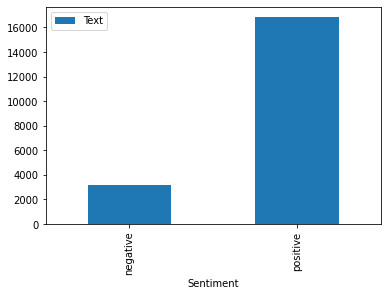

In [31]:
# Summarise class details
temp_df = df[['Text', 'Sentiment']]
temp_df = temp_df.groupby('Sentiment').count()
temp_df.plot.bar()

As we can see in the above output, there are 20,000 rows or reviews in this data set.

The data set consists of 3 columns,
- Id - Autogenerated incrementing number as row Id
- Text - Review text
- Sentiment - Label for sentiment (positive, negative)

## Data cleaning

If there are any missing values in the data set, corresponding entries need to be removed, because we cannot apply any preprocessing on them or use them for the model. 

The data set has 20,000 entries. So, it is a tedious task to check each row to find whether there is any missing value. 

To do this filtering automatically, we use <i>dropna</i> function available with <i>pandas</i> library.

More details about this function are available with this [tutorial](https://www.w3resource.com/pandas/dataframe/dataframe-dropna.php). 

In [33]:
# drop the rows where at least one element is missing
df = df.dropna()

print(f'Number of entries: {len(df)}')

Number of entries: 20000


Number of entries in the cleaned data set is similar to the number of entries in the original data set. That means there were no missing values in our data set.

## Data preprocessing

As data preprocessing techniques, we learned following.
- Tokenisation
- Text normalisation (lower casing, stemming and lemmatisation)
- Stop word removal
- Punctuation removal

Let's go through each step and apply it to the data set, if it is necessary or important to the targeted problem.


### Tokenisation

The first thing to do with tokenisation is selecting a tokenizer model. 

Under Text Preprocessing, we learned about 2 tokenizers as follows.
- *word_tokenize* - Tokenizer for normal text
- *TweetTokenizer* - Tokenizer for tweets

In this data set, we have normal text. Then we can use <i>word_tokenize</i>.

In [34]:
list_tokenised_text = []

# iterate through each row in 'Text' columm and convert text to tokens
for text in df['Text']:
  tokenized_text = word_tokenize(text)
  list_tokenised_text.append(tokenized_text)

print(list_tokenised_text[:2])

list_tokenised_sentences = []
for tokens in list_tokenised_text:
  text = ' '.join(tokens)
  list_tokenised_sentences.append(text)

# add new column to data frame
df['Tokenised_Text'] = list_tokenised_sentences

[['I', 'have', 'bought', 'several', 'of', 'the', 'Vitality', 'canned', 'dog', 'food', 'products', 'and', 'have', 'found', 'them', 'all', 'to', 'be', 'of', 'good', 'quality', '.', 'The', 'product', 'looks', 'more', 'like', 'a', 'stew', 'than', 'a', 'processed', 'meat', 'and', 'it', 'smells', 'better', '.', 'My', 'Labrador', 'is', 'finicky', 'and', 'she', 'appreciates', 'this', 'product', 'better', 'than', 'most', '.'], ['Product', 'arrived', 'labeled', 'as', 'Jumbo', 'Salted', 'Peanuts', '...', 'the', 'peanuts', 'were', 'actually', 'small', 'sized', 'unsalted', '.', 'Not', 'sure', 'if', 'this', 'was', 'an', 'error', 'or', 'if', 'the', 'vendor', 'intended', 'to', 'represent', 'the', 'product', 'as', '``', 'Jumbo', "''", '.']]


### Text normalisation

Under text normalisation, we discussed about 3 techniques; lower casing, stemming and lemmatisation.

Lower casing can be easily done by setting an argument in vectorizer.

Among stemming and lemmatisation, we will focus on lemmatisation in this tutorial because it is the more organised procedure.

In [35]:
wnl = WordNetLemmatizer()

list_lemmatised_tokens = []

# iterate through each list of tokens and lemmatise the tokens
for tokens in list_tokenised_text:
  lemma_words = []
  for word in tokens:
    lemma_word=wnl.lemmatize(word)
    lemma_words.append(lemma_word)
  list_lemmatised_tokens.append(lemma_words)
  
print(list_lemmatised_tokens[:2])

list_lemmatised_sentences = []
for tokens in list_lemmatised_tokens:
  text = ' '.join(tokens)
  list_lemmatised_sentences.append(text)

# add new column to data frame
df['Lemmatised_Text'] = list_lemmatised_sentences

[['I', 'have', 'bought', 'several', 'of', 'the', 'Vitality', 'canned', 'dog', 'food', 'product', 'and', 'have', 'found', 'them', 'all', 'to', 'be', 'of', 'good', 'quality', '.', 'The', 'product', 'look', 'more', 'like', 'a', 'stew', 'than', 'a', 'processed', 'meat', 'and', 'it', 'smell', 'better', '.', 'My', 'Labrador', 'is', 'finicky', 'and', 'she', 'appreciates', 'this', 'product', 'better', 'than', 'most', '.'], ['Product', 'arrived', 'labeled', 'a', 'Jumbo', 'Salted', 'Peanuts', '...', 'the', 'peanut', 'were', 'actually', 'small', 'sized', 'unsalted', '.', 'Not', 'sure', 'if', 'this', 'wa', 'an', 'error', 'or', 'if', 'the', 'vendor', 'intended', 'to', 'represent', 'the', 'product', 'a', '``', 'Jumbo', "''", '.']]


In [36]:
# save updated data frame to a file
# This step is optional for the main flow. But by saving data to a file you can analyse the preprocessed text output more deeply. 
df.to_csv('/content/reviews_preprocessed.csv', index=False)

df.head()

,Id,Text,Sentiment,Tokenised_Text,Lemmatised_Text
0,1,I have bought several of the Vitality canned d...,positive,I have bought several of the Vitality canned d...,I have bought several of the Vitality canned d...
1,2,Product arrived labeled as Jumbo Salted Peanut...,negative,Product arrived labeled as Jumbo Salted Peanut...,Product arrived labeled a Jumbo Salted Peanuts...
2,3,This is a confection that has been around a fe...,positive,This is a confection that has been around a fe...,This is a confection that ha been around a few...
3,4,If you are looking for the secret ingredient i...,negative,If you are looking for the secret ingredient i...,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...,positive,Great taffy at a great price . There was a wid...,Great taffy at a great price . There wa a wide...


### Stop word removal

To convert text into numeric features, we use vectorizers (CountVectorizer, TfidfVectorizer). Stop word removal can be easily done by giving a stop word list as an argument to the vectorizer. So, during the preprocessing step, we need to figure out a suitable stop word list.

Let's look at the English stop words list available with NLTK library.

In [37]:
# get English stopwords
stop_words = set(stopwords.words('english')) 
print(stop_words)

{'nor', 'because', 'hasn', 'wouldn', 'didn', 'few', 'don', 'out', 'against', 'yours', "don't", 'shouldn', 'any', "she's", 'am', 'weren', "wouldn't", 'when', 'wasn', 'no', 'i', 'which', "you'd", 'do', 'or', 'while', 'myself', 'too', 'been', 'can', 'them', "mightn't", 'now', 'down', 'just', 'their', 'd', 'again', "hadn't", "haven't", 'was', 'itself', 'both', 's', 'ain', 'themselves', "aren't", 'after', 'between', 'own', 'y', 'doesn', 'at', 'then', 'for', 'have', 'who', 'she', 'his', 'until', 'to', 'its', 'yourselves', 'they', 'having', 're', 'ma', 'such', 'whom', "mustn't", 'were', 'mightn', 'on', 'he', "you've", 'once', 'than', 'before', 'if', "weren't", "isn't", 'as', 'should', 'her', "couldn't", 'needn', 'did', 'some', "shouldn't", 'off', "didn't", 'into', "needn't", 'most', "you're", 'you', 'isn', 'up', 'hadn', 'over', 'haven', "won't", 'where', 'we', 'o', 'by', 'theirs', 'above', 'there', 'of', 'has', "hasn't", 'why', 'hers', 'from', "that'll", 'will', 'my', 'ours', 'in', 'during', 

<b>Is the above list suitable for this analysis? </b>

The above list contains the words <i>no, not, aren't, isn't</i>, etc. which are commonly used to express negative sentiment. By removing them, some important tokens will be removed. 

Therefore, stop word removal using the above list is not appropriate for this analysis. This inappropriateness will be further confirmed with the model accuracies reported below. In such scenarios, you should either change the list to make it suitable for the analysis or skip stop word removal preprocessing step. 

<b>REMEMBER!</b> Even though the stop word removal is not appropriate for this analysis, there are lot of text analysis tasks which need this step.


### Punctuation removal

To convert text into numeric features, we use vectorizers (CountVectorizer, TfidfVectorizer). As we already learned, punctuation removal can be easily handled with the vectorizer. Thus, no any preprocessing step is needed.

### Summary
We went through all text preprocessing steps, discussed their appropriateness  and applied them to the data set.

In summary, now we have a data frame named <i>df</i> with following columns.
- 'Id' - Ids
- 'Text' - original text data
- 'Sentiment' - labels
- 'Tokenised_Text' - tokenised text
- 'Lemmatised_Text' - lemmatised text

Also a list of stop words (stop_words).

## Text feature extraction and model generation

We can convert text into numeric features using term occurrence vectors or tf-idf vectors. This conversion can be easily done using CountVectorizer or TfidfVectorizer.

As classification algorithms, you learned SVM, Naive Bayes and decision trees under Machine Learning module. To make things simpler, let's focus on SVM for our initial experiments to understand the impact by different data preprocessing techniques and features. Later we can extend the experiments to other algorithms. 



Looking at available data preprocessing techniques and features, we can make different combinations to tryout different models.

To make things clear, I am using lower casing and punctuation removal as default preprocessing steps and any changes other than that are mentioned in the table. 

|Model | Data Preprocessing | Features   |
|------|--------------------|------------|
|M1    |-| term occurrence vector(1-grams) | 
|M2    |-| tf-idf vector(1-grams) | 
|M3    |tokenisation(NLTK) | <i> \<best amoung M1 and M2\> | 
|M4    |lemmatisation(WordNet) | <i> \<best amoung M1 and M2\> |
|M5    |tokenisation(NLTK), stop word removal | <i> \<best amoung M1 and M2\> | 
|M6    |lemmatisation(WordNet), stop word removal | <i> \<best amoung M1 and M2\> |

Initially we will compare the performance of  term occurrence vectors and tf-idf vectors. Then the best vector representation will be used with other data preprocessing techniques. 

Let's follow these combinations and check their impact on model accuracy.

<b>NOTE!</b> All combinations are not listed here.

As the first step, we need to separate data into a training set and validation set.

In [38]:
# use raw text
X_train_text, X_val_text, y_train, y_val = train_test_split(df['Text'], df['Sentiment'], test_size=0.3, random_state=100)
print(f'training data set size: {len(X_train_text)}')
print(f'testing data set size: {len(X_val_text)}')

# use tokenised text
X_train_tokenised_text, X_val_tokenised_text, y_train, y_val = train_test_split(df['Tokenised_Text'], df['Sentiment'], test_size=0.3, random_state=100)
print(f'training data set size: {len(X_train_tokenised_text)}')
print(f'testing data set size: {len(X_val_tokenised_text)}')

# use lemmatised text
X_train_lemmatised_text, X_val_lemmatised_text, y_train, y_val = train_test_split(df['Lemmatised_Text'], df['Sentiment'], test_size=0.3, random_state=100)
print(f'training data set size: {len(X_train_lemmatised_text)}')
print(f'testing data set size: {len(X_val_lemmatised_text)}')

training data set size: 14000
testing data set size: 6000
training data set size: 14000
testing data set size: 6000
training data set size: 14000
testing data set size: 6000


In [39]:
# method to plot confusion matrix
def plot_confusion_matrix(matrix):
    plt.clf()
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Set2_r)
    classNames = ['Positive', 'Negative']
    plt.title('Confusion Matrix')
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TP','FP'], ['FN', 'TN']]

    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(matrix[i][j]))
    plt.show()

# method to calculate evaluation results
def evaluate(actuals, predictions):
  accuracy = metrics.accuracy_score(actuals, predictions)
  confusion_matrix = metrics.confusion_matrix(actuals, predictions)
  return accuracy, confusion_matrix

### SVM

In [40]:
# method to train and predict using SVM classifier
def get_svm_predictions(X_train, X_val, y_train, y_val):
  # build model
  clf = svm.SVC(kernel='linear', random_state=100) 
  clf.fit(X_train, y_train)

  # Make predictions on test data
  y_pred = clf.predict(X_val)

  # evalution
  accuracy, confusion_matrix = evaluate(y_val, y_pred)
  print(f'Accuracy: {accuracy}')
  plot_confusion_matrix(confusion_matrix)

  return clf

#### Model M1

Accuracy: 0.905


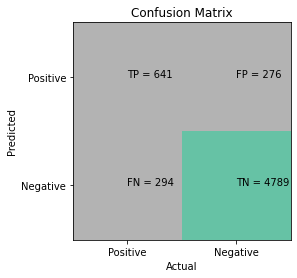

In [41]:
# Data preprocessing - lower casing, punctuation removal
# Features - term occurrence vector (1-grams)

vectorizer = CountVectorizer()  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_text)
X_val = vectorizer.transform(X_val_text)

model = get_svm_predictions(X_train, X_val, y_train, y_val)

#### Model M2

Accuracy: 0.9228333333333333


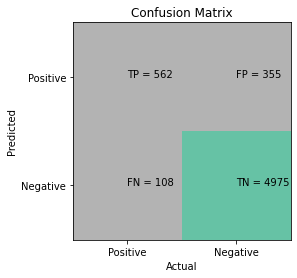

In [ ]:
# Data preprocessing - lower casing, punctuation removal
# Features - tf-idf vector (1-grams)

vectorizer = TfidfVectorizer()  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_text)
X_val = vectorizer.transform(X_val_text)

model = get_svm_predictions(X_train, X_val, y_train, y_val)

#### Model M3

Accuracy: 0.9225


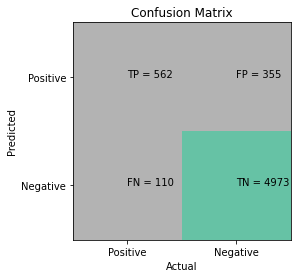

In [ ]:
# Data preprocessing - lower casing, punctuation removal, tokenisation(NLTK)
# Features - tf-idf vector (1-grams)

vectorizer = TfidfVectorizer()  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_tokenised_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_tokenised_text)
X_val = vectorizer.transform(X_val_tokenised_text)

model = get_svm_predictions(X_train, X_val, y_train, y_val)

#### Model M4

Accuracy: 0.921


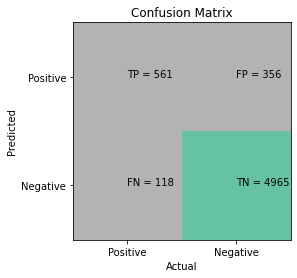

In [ ]:
# Data preprocessing - lower casing, punctuation removal, lemmatisation(WordNet)
# Features - tf-idf vector (1-grams)

vectorizer = TfidfVectorizer()  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_lemmatised_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_lemmatised_text)
X_val = vectorizer.transform(X_val_lemmatised_text)

model = get_svm_predictions(X_train, X_val, y_train, y_val)

#### Model M5

Accuracy: 0.9211666666666667


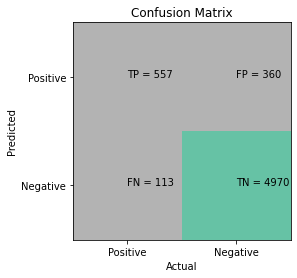

In [ ]:
# Data preprocessing - lower casing, punctuation removal, tokenisation(NLTK), stop word removal
# Features - tf-idf vector (1-grams)

vectorizer = TfidfVectorizer(stop_words=stop_words)  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_tokenised_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_tokenised_text)
X_val = vectorizer.transform(X_val_tokenised_text)

model = get_svm_predictions(X_train, X_val, y_train, y_val)

#### Model M6

Accuracy: 0.9198333333333333


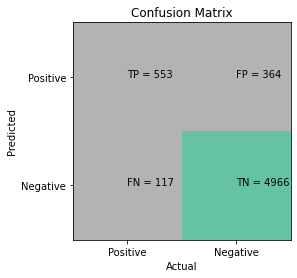

In [ ]:
# Data preprocessing - lower casing, punctuation removal, lemmatisation(WordNet), stop word removal
# Features - tf-idf vector (1-grams)

vectorizer = TfidfVectorizer(stop_words=stop_words)  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_lemmatised_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_lemmatised_text)
X_val = vectorizer.transform(X_val_lemmatised_text)

model = get_svm_predictions(X_train, X_val, y_train, y_val)

#### Summary 1
Based on our finding up to now, the above table can be updated to following version.

|Model | Data Preprocessing | Features   |Accuracy|
|------|--------------------|------------|--------|
|M1    |-| term occurrence vector(1-grams) | 0.9050 |
|M2    |-| tf-idf vector(1-grams) | 0.9228 |
|M3    |tokenisation(NLTK) | tf-idf vector(1-grams) | 0.9225 |
|M4    |lemmatisation(WordNet) | tf-idf vector(1-grams) | 0.9210 |
|M5    |tokenisation(NLTK), stop word removal | tf-idf vector(1-grams) | 0.9212 |
|M6    |lemmatisation(WordNet), stop word removal | tf-idf vector(1-grams) | 0.9198 |

Best accuracy so far is obtained by model M2. As we can see lemmatisation and stop word removal do not increase the accuracy of model **for this data**.

As the next step, let's see how n-grams can affect the accuracy.

#### Model M7

Accuracy: 0.9325


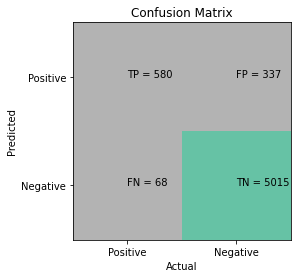

In [ ]:
# Data preprocessing - lower casing, punctuation removal
# Features - tf-idf vector (1-grams, 2-grams)

vectorizer = TfidfVectorizer(ngram_range=(1,2))  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_text)
X_val = vectorizer.transform(X_val_text)

model = get_svm_predictions(X_train, X_val, y_train, y_val)

#### Summary 2

|Model | Data Preprocessing | Features   |Accuracy|
|------|--------------------|------------|--------|
|M1    |-| term occurrence vector(1-grams) | 0.9050 |
|M2    |-| tf-idf vector(1-grams) | 0.9228 |
|M3    |tokenisation(NLTK) | tf-idf vector(1-grams) | 0.9225 |
|M4    |lemmatisation(WordNet) | tf-idf vector(1-grams) | 0.9210 |
|M5    |tokenisation(NLTK), stop word removal | tf-idf vector(1-grams) | 0.9212 |
|M6    |lemmatisation(WordNet), stop word removal | tf-idf vector(1-grams) | 0.9198 |
|M7    |-| tf-idf vector(1-grams, 2-grams) | 0.9325 |

Based on the experiments we conducted so far, best accuracy was obtained for model M7. 

<b>Exercise 1.</b> Check other possible data preprocessing and feature combinations to find out whether you can increase the accuracy further. Also, try tuning hyper-parameters of SVM algorithm based on the knowledge you gained during Machine Learning module.

### Other algorithms

#### Decision Tree

In [ ]:
# method to train and predict using Decision Tree
def get_dt_predictions(X_train, X_val, y_train, y_val):
  # build model
  clf = tree.DecisionTreeClassifier(random_state=100)
  clf.fit(X_train, y_train)

  # Make predictions on test data
  y_pred = clf.predict(X_val)

  # evalution
  accuracy, confusion_matrix = evaluate(y_val, y_pred)
  print(f'Accuracy: {accuracy}')
  plot_confusion_matrix(confusion_matrix)

  return clf

Accuracy: 0.8385


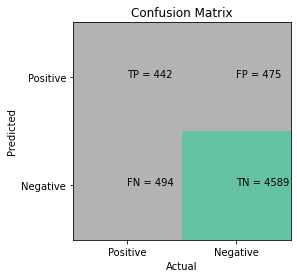

In [ ]:
# Data preprocessing - lower casing, punctuation removal
# Features - tf-idf vector (1-grams)

vectorizer = TfidfVectorizer()  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_text)
X_val = vectorizer.transform(X_val_text)

model = get_dt_predictions(X_train, X_val, y_train, y_val)

#### Naive Bayes

In [ ]:
# method to train and predict using Naive Bayes classifier
def get_nb_predictions(X_train, X_val, y_train, y_val):
  # build model
  clf = GaussianNB()
  clf.fit(X_train.toarray(), y_train)

  # Make predictions on test data
  y_pred = clf.predict(X_val.toarray())

  # evalution
  accuracy, confusion_matrix = evaluate(y_val, y_pred)
  print(f'Accuracy: {accuracy}')
  plot_confusion_matrix(confusion_matrix)

  return clf

Accuracy: 0.5788333333333333


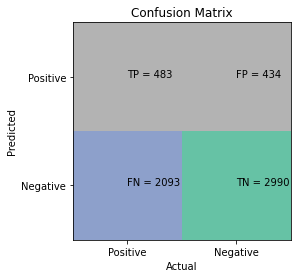

In [ ]:
# Data preprocessing - lower casing, punctuation removal
# Features - tf-idf vector (1-grams)

vectorizer = TfidfVectorizer()  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_text)
X_val = vectorizer.transform(X_val_text)

model = get_nb_predictions(X_train, X_val, y_train, y_val)

## Test performance

In [ ]:
test_reviews = ["My absolute favorite Yogi tea!  Pleasantly spicy, with a hint of rich chocolate.  I much prefer this to the Mayan Cocoa Spice & Sweet Thai flavors.  It's what I reach for when I get a craving for a cup of hot chocolate but don't want the calories.",
                "The price is good, size is perfect...but my dog doesn't like them at all. Would not buy again sorry. Not the products fault",
                "My dog loves the taste of these...they're a nice change from rawhides..I feel like I can give him treats more often",
                "I buy stuff like this for the grand kids. I think they liked it.  I cannot eat pre-packaged foods due to health concerns. I haven't heard anything negative, so it must have been ok.",
                "Yuck!  This is the first time this tasted bland.  Is something different with this batch?"]

Select best model

Accuracy: 0.9325


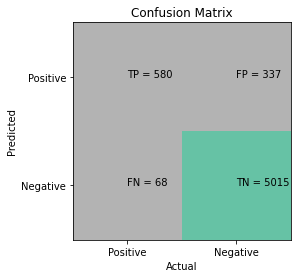

In [ ]:
# Data preprocessing - lower casing, punctuation removal
# Features - tf-idf vector (1-grams, 2-grams)

vectorizer = TfidfVectorizer(ngram_range=(1,2))  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_text)
X_val = vectorizer.transform(X_val_text)

model = get_svm_predictions(X_train, X_val, y_train, y_val)

Apply same preprocessing techniques used with model data to test reviews

In [ ]:
# preprocessing used with Model M7 - lower casing, punctuation removal
X_test = vectorizer.transform(test_reviews)
predictions = model.predict(X_test)
print(predictions)

['positive' 'negative' 'positive' 'positive' 'negative']
